# 1. Define binning and model

In [1]:
%load_ext autoreload
%autoreload 2

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pyhf
import cabinetry
import json
import yaml
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util

Welcome to JupyROOT 6.26/14


In [2]:
cabinetry.set_logging()

In [7]:
# Define the fitting range and number of bins, 'p_D_l'
start = 0.4
end = 4.8
num_bins = 50

# Create the bin edges
p_D_l_bins = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -2.5
end = 10
num_bins = 50

# Create the bin edges
MM2_bins = np.linspace(start, end, num_bins + 1)


# Check for empty bins
# empty_bins = [41, 42, 43, 44, 46, 47, 48, 49]

# Merge adjacent empty bins
# merged_bins = np.delete(bins, empty_bins)

# Define relevant variables
training_variables = util.training_variables

In [8]:
## Loading Ntuples
columns = util.all_relevant_variables

cut = '(5<B0_roeMbc_my_mask) & (-4<B0_roeDeltae_my_mask) & (B0_roeDeltae_my_mask<1)'

# Load data files
e_generic = uproot.concatenate([f'../Samples/Generic_MC15ri/e_channel/MC15ri_1ab_quaxo_e_2/*.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

# e_sig = uproot.concatenate([f'../Samples/Generic_MC15ri/e_channel/MC15ri_sig_quaxo_e_1/*.root:B0'],
#                           library="np",
#                           cut = cut,
#                           filter_branch=lambda branch: branch.name in columns)

In [9]:
df_e_generic = pd.DataFrame(e_generic).sample(frac=0.4).reset_index(drop=True)
# df_e_sig = pd.DataFrame(e_sig)

lgb_tight = 'sig_prob==largest_prob and sig_prob>0.65 and fakeD_prob<0.05'

for df in [df_e_generic]:#,df_e_sig]:
    df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
    df.eval('p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

df_e_generic_lgb = util.apply_mva_bcs(df_e_generic, training_variables, lgb_tight, library='lgbm')
# df_e_sig_lgb = util.apply_mva_bcs(df_e_sig, training_variables, lgb_tight, library='lgbm')



# mu_temp = uproot.concatenate([f'../Samples/Generic_MC15ri/mu_channel/MC15ri_local_200fb/*.root:B0'],
#                           library="np",
#                           #cut=input_cut,
#                           filter_branch=lambda branch: branch.name in columns)

# df_mu = pd.DataFrame(mu_temp)
# df_mu['__weight__'] = 5

# df_mu.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
# df_mu.eval(f'p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

In [10]:
t_e_generic = util.classify_mc_dict(df_e_generic_lgb, 'e', template=False)
# t_e_sig = util.get_dataframe_samples_new(df_e_sig_lgb, 'e', template=False)

for name, df in t_e_generic.items():
    print(name, len(df))

bkg_fakeD 19342
bkg_TDFl 2513
bkg_fakeTracks 1107
bkg_continuum 5351
bkg_combinatorial 5967
bkg_singleBbkg 3805
bkg_other_TDTl 0
$D\tau\nu$ 1707
$D^\ast\tau\nu$ 1003
$D\ell\nu$ 36158
$D^\ast\ell\nu$ 22928
$D^{\ast\ast}\tau\nu$ 605
$D^{\ast\ast}\ell\nu$_narrow 7344
$D^{\ast\ast}\ell\nu$_broad 5703
$D\ell\nu$_gap_pi 1393
$D\ell\nu$_gap_eta 1244
bkg_other_signal 0


In [ ]:
for name, df in t_e_sig.items():
    print(name, len(df))

In [ ]:
sig_comp = [r'$D\tau\nu$', r'$D^\ast\tau\nu$', r'$D^{\ast\ast}\tau\nu$']
te = {k:v for k,v in t_e_generic.items() if k not in sig_comp}
for c_name in sig_comp:
    te[c_name] = t_e_sig[c_name]
    
for name, df in te.items():
    print(name, len(df))

# 2. Create templates

In [12]:
## luminosity == 400/fb
indices_threshold_e,temp_asimov_e,temp_with_sb,temp_asimov_merged_e = util.create_templates(
    samples=t_e_generic, bins=[MM2_bins, p_D_l_bins], scale_lumi=1, fakeD_from_sideband=True,
    data = None, #df_e_generic_lgb.query('D_M<1.83 or 1.91<D_M').sample(frac=0.4),
    variables=['B0_CMS3_weMissM2','p_D_l'], bin_threshold=5,merge_threshold=5,
    sample_to_exclude=['bkg_fakeTracks','bkg_other_TDTl','bkg_other_signal'],
    sample_weights={r'$D^{\ast\ast}\ell\nu$_broad':1,
                    r'$D\ell\nu$_gap_pi':1, 
                    r'$D\ell\nu$_gap_eta':1,
#                     r'$D\tau\nu$': 4431/19505, 
#                     r'$D^\ast\tau\nu$': 2629/10179, 
#                     r'$D^{\ast\ast}\tau\nu$': 1571/18450
                    })
# (template_flat_e,staterr_flat_e,asimov_data_e) = temp_asimov_e
# (template_flat_e_merged,staterr_flat_e_merged,asimov_data_e_merged) = temp_asimov_merged_e

# indices_threshold_mu,temp_asimov_mu,temp_asimov_merged_mu = util.create_templates(
#     samples=tmu, bins=[MM2_bins, p_D_l_bins], scale_lumi=True,
#     variables=['B0_CMS3_weMissM2','p_D_l'],
#     bin_threshold=1,merge_threshold=10,
#     sample_to_exclude=[#'bkg_FakeD','bkg_TDFl','bkg_continuum','bkg_combinatorial','bkg_singleBbkg',
#                        'bkg_fakeTracks','bkg_other_TDTl','bkg_other_signal'])

Creating the fakeD template from the sidebands
initial parameters= [ 2.8300e+01  1.8700e+00  7.0000e-02  1.4170e+04 -6.0350e+02  1.6014e+03]
Yields from 1.79 to 1.82 = 7675.954 ± 87.347
Yields from 1.855 to 1.885 = 7085.002 ± 59.519
Yields from 1.92 to 1.95 = 6494.051 ± 80.297
sig/left = 0.923+/-0.007,         sig/right = 1.091+/-0.010
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 692, now is 685
creating a new template with merged bins, original template length = 685, new template (merge small bins) length = 685


In [7]:
temp_o, data_o = util.create_2d_template_from_1d(*temp_asimov_e,
                            indices_threshold=indices_threshold_e, bins=[MM2_bins, p_D_l_bins])
temp_sb, data_sb = util.create_2d_template_from_1d(*temp_with_sb,
                            indices_threshold=indices_threshold_e, bins=[MM2_bins, p_D_l_bins])

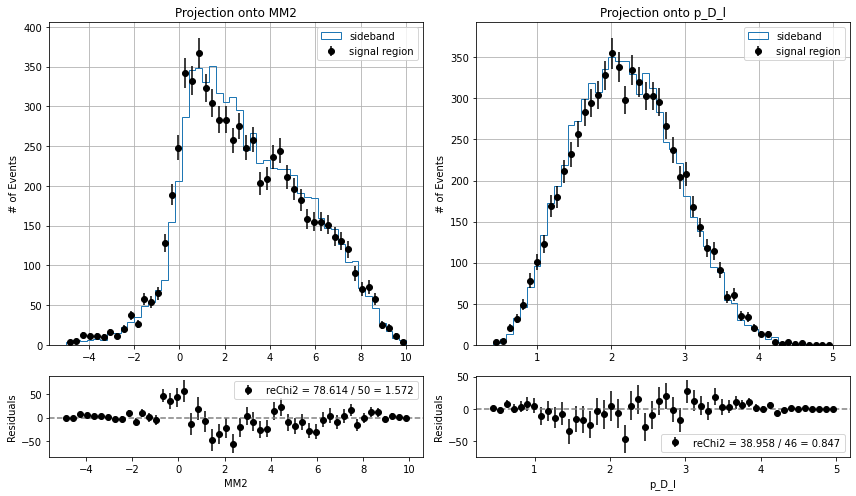

In [8]:
util.compare_2d_hist(temp_o['bkg_fakeD'], temp_sb['bkg_fakeD'], bins_x=MM2_bins, bins_y=p_D_l_bins, 
                       xlabel='MM2', ylabel='p_D_l', data_label='signal region', model_label='sideband')

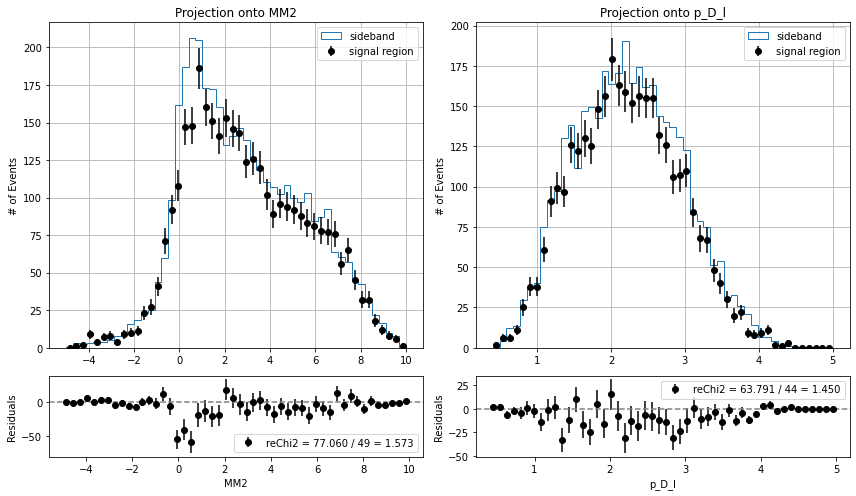

In [13]:
util.compare_2d_hist(temp_o['bkg_fakeD'], temp_sb['bkg_fakeD'], bins_x=MM2_bins, bins_y=p_D_l_bins, 
                       xlabel='MM2', ylabel='p_D_l', data_label='signal region', model_label='sideband')

In [ ]:
util.inspect_temp_asimov_channels([(temp_o, data_o)], [(temp_sb,data_sb)])

In [ ]:
sig_ch = util.extract_temp_asimov_channels(spec_e,mc_uncer=True)
sb_ch = util.extract_temp_asimov_channels(spec_e_sb,mc_uncer=True)
util.inspect_temp_asimov_channels(sig_ch,sb_ch)

# 3. Create a pyhf workspace

In [23]:
spec_e = cabinetry.workspace.load('../Fit_toys/2d_ws_SR_e_50_50_fakeDUncer_400fb.json')
spec_e_sb = cabinetry.workspace.load('../Fit_toys/2d_ws_SBFakeD_e_50_50_fakeDUncer_400fb.json')

In [21]:
# update templates and data in the workspace
# signal region
spec_e = util.create_workspace(temp_asimov_channels=[temp_asimov_e],
                               mc_uncer=False,fakeD_uncer=False)

print(json.dumps(spec_e, sort_keys=True, indent=4))

cabinetry.workspace.save(spec_e, '../Fit_toys/2d_ws_SR_e_50_50_noUncer_400fb.json')

{
    "channels": [
        {
            "name": "channel_0",
            "samples": [
                {
                    "data": [
                        5.0,
                        12.0,
                        28.0,
                        35.0,
                        3.0,
                        3.0,
                        1.0,
                        20.0,
                        3.0,
                        8.0,
                        22.0,
                        2.0,
                        21.0,
                        1.0,
                        11.0,
                        12.0,
                        6.0,
                        18.0,
                        5.0,
                        23.0,
                        1.0,
                        5.0,
                        10.0,
                        3.0,
                        23.0,
                        3.0,
                        14.0,
                        14.0,
                        1.0,
         

DEBUG - cabinetry.workspace - saving workspace to ../Fit_toys/2d_ws_SR_e_50_50_noUncer_400fb.json


In [12]:
!pyhf inspect giordon_spec.json

                     Summary       
               ------------------  
                  channels  1
                   samples  12
                parameters  13
                 modifiers  13

                  channels  nbins
                ----------  -----
                  electron  1111 

                   samples
                ----------
                $D\ell\nu$
            $D\ell\nu$_gap
                $D\tau\nu$
           $D^\ast\ell\nu$
           $D^\ast\tau\nu$
     $D^{\ast\ast}\ell\nu$
     $D^{\ast\ast}\tau\nu$
                  bkg_TDFl
         bkg_combinatorial
             bkg_continuum
                 bkg_fakeD
            bkg_singleBbkg

                parameters  constraint              modifiers
                ----------  ----------              ----------
       $D\ell\nu$_gap_norm  unconstrained           normfactor
           $D\ell\nu$_norm  unconstrained           normfactor
           $D\tau\nu$_norm  unconstrained           normfactor
      $D

In [22]:
# update templates and data in the workspace
# signal region with fakeD from sidebands
spec_e_sb = util.create_workspace(temp_asimov_channels=[temp_with_sb],
                                  mc_uncer=False,fakeD_uncer=False)

print(json.dumps(spec_e_sb, sort_keys=True, indent=4))

cabinetry.workspace.save(spec_e_sb, '../Fit_toys/2d_ws_SBFakeD_e_50_50_noUncer_400fb.json')

{
    "channels": [
        {
            "name": "channel_0",
            "samples": [
                {
                    "data": [
                        4.0086,
                        12.7872,
                        21.5892,
                        24.3277,
                        0.7197,
                        3.7345,
                        1.9216,
                        21.5074,
                        3.9979,
                        6.5328,
                        17.6397,
                        2.6435,
                        17.2871,
                        0.8796,
                        3.7337,
                        13.9317,
                        3.6478,
                        21.537,
                        8.476,
                        20.5592,
                        1.091,
                        6.0869,
                        3.9373,
                        4.806,
                        18.28,
                        5.5893,
                        25.0

DEBUG - cabinetry.workspace - saving workspace to ../Fit_toys/2d_ws_SBFakeD_e_50_50_noUncer_400fb.json


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

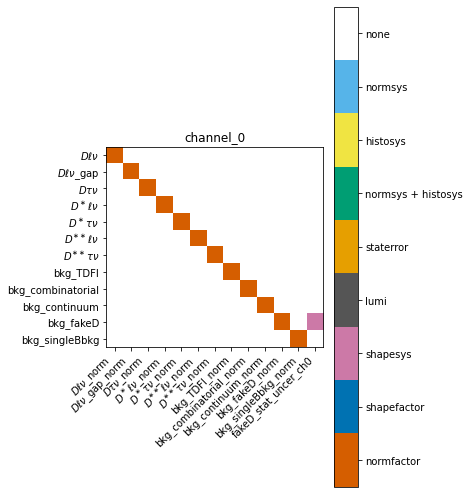

In [15]:
cabinetry.visualize.modifier_grid(pyhf.Workspace(spec_e).model())

In [4]:
model_sr, data_sr = cabinetry.model_utils.model_and_data(spec_e)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

In [6]:
# compare the difference between pyhf suggested_init and cabinetry asimov_parameters

par_val = [2]*12
par_fix = ['bkg_fakeD_norm','bkg_combinatorial_norm','bkg_continuum_norm',
           'bkg_singleBbkg_norm','bkg_TDFl_norm']

# Get norm parameter names in the correct order
norm_parameter_names = [par for par in model_sr.config.par_order if par.endswith('_norm')]
# Create a list of parameter names for samples that are not fixed
minos_parameters = [par for par in norm_parameter_names if par not in par_fix]
# Create a boolean list for fixing parameters
fix_mask = [par in par_fix for par in norm_parameter_names]

# set up the model configuration
for i, par_name in enumerate(norm_parameter_names):
    model_sr.config.par_map[par_name]['paramset'].suggested_init=[par_val[i]]
    model_sr.config.par_map[par_name]['paramset'].suggested_fixed=fix_mask[i]

# print(model_sr.config.suggested_init() )
# print(model_sr.config.suggested_fixed())
print(list(cabinetry.model_utils.asimov_parameters(model_sr))==model_sr.config.suggested_init())

toy_pars = cabinetry.model_utils.asimov_parameters(model_sr)
pdf_toy = model_sr.make_pdf(pyhf.tensorlib.astensor(toy_pars))
toys = pdf_toy.sample((2,))
toys

In [ ]:
%%time
## 200/fb with fakeD from sidebands, binning=50,50
pyhf.set_backend("jax")
fit_results = cabinetry.fit.fit(model=model_sr, data=data_sr,goodness_of_fit=True)

In [25]:
model_sr, data_sr = cabinetry.model_utils.model_and_data(spec_e)
model_sbFakeD, data_sbFakeD = cabinetry.model_utils.model_and_data(spec_e_sb)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

# 4. Asimov fit

In [34]:
model_sbFakeD.config.par_order

['$D\\ell\\nu$_norm',
 '$D\\ell\\nu$_gap_norm',
 '$D\\tau\\nu$_norm',
 '$D^\\ast\\ell\\nu$_norm',
 '$D^\\ast\\tau\\nu$_norm',
 '$D^{\\ast\\ast}\\ell\\nu$_norm',
 '$D^{\\ast\\ast}\\tau\\nu$_norm',
 'bkg_TDFl_norm',
 'bkg_combinatorial_norm',
 'bkg_continuum_norm',
 'bkg_fakeD_norm',
 'bkg_singleBbkg_norm',
 'mc_uncer_channel0']

In [6]:
init_pars = model_sr.config.suggested_init()
init_pars[10] = 1

In [8]:
%%time
## 200/fb with fakeD from sidebands, binning=50,50
pyhf.set_backend("jax")
fit_results = cabinetry.fit.fit(model=model_sr, data=data_sr,init_pars=init_pars,
                                fix_pars=[False, True, False, False, False, False, False] +[True]*5,
                                minos=model_sr.config.parameters[:7])

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5061                       │              Nfcn = 51               │
│ EDM = 4.02e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - running MINOS for $D^\ast\ell\nu$_norm
INFO - cabinetry.fit - running MINOS for $D^\ast\tau\nu$_norm
INFO - cabinetry.fit - running MINOS for $D^{\ast\ast}\ell\nu$_norm
INFO - cabinetry.fit - running MINOS for $D^{\ast\ast}\tau\nu$_norm
INFO - cabinetry.fit - MINOS results:
INFO - cabinetry.fit - $D\ell\nu$_norm            =  1.0000 -0.0057 +0.0057
INFO - cabinetry.fit - $D\tau\nu$_norm            =  1.0000 -0.1743 +0.1743
INFO - cabinetry.fit - $D^\ast\ell\nu$_norm       =  1.0000 -0.0117 +0.0117
INFO - cabinetry.fit - $D^\ast\tau\nu$_norm       =  1.0000 -0.2299 +0.2308
INFO - cabinetry.fit - $D^{\ast\ast}\ell\nu$_norm =  1.0000 -0.0196 +0.0197
INFO - cabinetry.fit - $D^{\ast\ast}\tau\nu$_norm =  1.0000 -0.3273 +0.3284
DEBUG - cabinetry.fit - -2 log(L) = 5061.066191 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\ell\nu$_norm            =  1.0000 +/- 0.0057
INFO - cabinetry.fit - $D\ell\nu$_gap_norm

CPU times: user 608 ms, sys: 26 ms, total: 634 ms
Wall time: 636 ms


In [24]:
%%time
## 200/fb with fakeD from sidebands, binning=60,60
pyhf.set_backend("jax")
fit_results = cabinetry.fit.fit(model=model_sbFakeD, data=data_sr,
                                fix_pars=[False]*7+[True]*5)#, minos=model.config.parameters[:7])

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6698                       │      Nfcn = 244795, Ngrad = 29       │
│ EDM = 0.00149 (Goal: 0.0002)     │           time = 135.7 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   

INFO - cabinetry.fit - fakeD_stat_uncer_ch0[86]   =  0.5268 +/- 0.5028
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[87]   =  0.5524 +/- 0.1678
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[88]   =  3.9928 +/- 1.9418
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[89]   =  0.3999 +/- 0.2797
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[90]   =  0.3549 +/- 0.3396
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[91]   =  0.7431 +/- 0.2604
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[92]   =  0.5081 +/- 0.1598
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[93]   =  0.5050 +/- 0.1115
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[94]   =  0.0682 +/- 0.0676
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[95]   =  0.9386 +/- 0.1840
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[96]   =  0.5911 +/- 0.5767
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[97]   =  9.9999 +/- 1.7193
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[98]   =  1.0523 +/- 1.0190
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[99]   =  0.8881 +/- 0.1964
INFO -

INFO - cabinetry.fit - fakeD_stat_uncer_ch0[202]  =  0.5358 +/- 0.5246
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[203]  =  0.9055 +/- 0.1870
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[204]  =  0.4167 +/- 0.1467
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[205]  =  0.2243 +/- 0.1560
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[206]  =  0.2403 +/- 0.2376
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[207]  =  0.6753 +/- 0.1323
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[208]  =  0.2350 +/- 0.1640
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[209]  =  0.4504 +/- 0.0893
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[210]  =  0.2950 +/- 0.0753
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[211]  =  0.3655 +/- 0.3588
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[212]  =  1.0884 +/- 0.6088
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[213]  =  0.7036 +/- 0.4793
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[214]  =  0.1709 +/- 0.1693
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[215]  =  0.4674 +/- 0.2081
INFO -

INFO - cabinetry.fit - fakeD_stat_uncer_ch0[318]  =  0.4099 +/- 0.1019
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[319]  =  0.4808 +/- 0.1804
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[320]  =  0.4161 +/- 0.1000
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[321]  =  0.7171 +/- 0.4811
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[322]  =  0.5856 +/- 0.1153
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[323]  =  0.4039 +/- 0.1018
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[324]  =  0.5003 +/- 0.4913
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[325]  =  0.9120 +/- 0.4101
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[326]  =  0.8467 +/- 0.2246
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[327]  =  1.7120 +/- 1.6387
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[328]  =  0.5614 +/- 0.2203
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[329]  =  0.4778 +/- 0.1083
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[330]  =  0.1959 +/- 0.0970
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[331]  =  0.5335 +/- 0.0917
INFO -

INFO - cabinetry.fit - fakeD_stat_uncer_ch0[434]  =  1.2179 +/- 1.1755
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[435]  =  0.3455 +/- 0.1127
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[436]  =  0.3068 +/- 0.1358
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[437]  =  0.6512 +/- 0.1208
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[438]  =  2.1868 +/- 1.0486
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[439]  =  0.4069 +/- 0.1466
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[440]  =  1.0365 +/- 0.2318
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[441]  =  0.8706 +/- 0.2497
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[442]  =  4.6123 +/- 1.1993
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[443]  =  0.3933 +/- 0.1290
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[444]  =  3.0730 +/- 2.0447
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[445]  =  0.6039 +/- 0.1407
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[446]  =  0.5235 +/- 0.1291
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[447]  =  0.1747 +/- 0.1692
INFO -

INFO - cabinetry.fit - fakeD_stat_uncer_ch0[550]  =  0.2998 +/- 0.2099
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[551]  =  2.1685 +/- 0.6765
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[552]  =  0.0349 +/- 0.0346
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[553]  =  0.5759 +/- 0.1421
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[554]  =  0.7715 +/- 0.1668
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[555]  =  0.8689 +/- 0.2292
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[556]  =  0.5221 +/- 0.5020
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[557]  =  0.9200 +/- 0.1933
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[558]  =  1.1658 +/- 0.8002
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[559]  =  0.3466 +/- 0.0847
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[560]  =  1.4919 +/- 0.4672
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[561]  =  0.1555 +/- 0.1549
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[562]  =  0.5099 +/- 0.2916
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[563]  =  0.5462 +/- 0.3079
INFO -

INFO - cabinetry.fit - fakeD_stat_uncer_ch0[666]  =  0.5842 +/- 0.1610
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[667]  =  0.6347 +/- 0.1160
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[668]  =  0.1650 +/- 0.1150
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[669]  =  0.2113 +/- 0.2062
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[670]  =  1.5249 +/- 0.7517
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[671]  =  0.4804 +/- 0.1377
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[672]  =  1.6330 +/- 0.5381
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[673]  =  1.3413 +/- 1.2928
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[674]  =  0.7997 +/- 0.1548
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[675]  =  1.6275 +/- 0.8847
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[676]  =  0.3287 +/- 0.1332
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[677]  =  0.6241 +/- 0.3462
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[678]  =  0.4254 +/- 0.0867
INFO - cabinetry.fit - fakeD_stat_uncer_ch0[679]  =  1.0000 +/- 0.9815
INFO -

CPU times: user 3min 56s, sys: 5.92 s, total: 4min 2s
Wall time: 3min 8s


INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


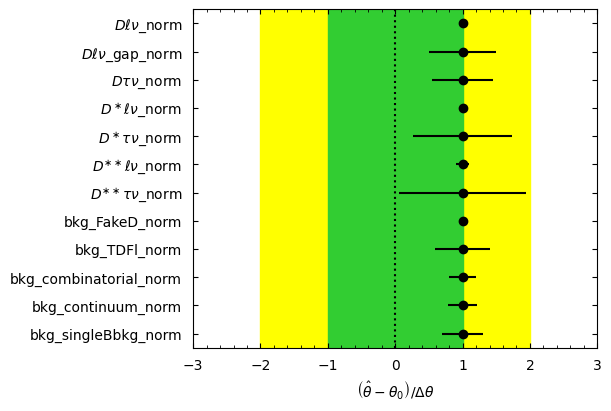

In [22]:
cabinetry.visualize.pulls(fit_results)

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


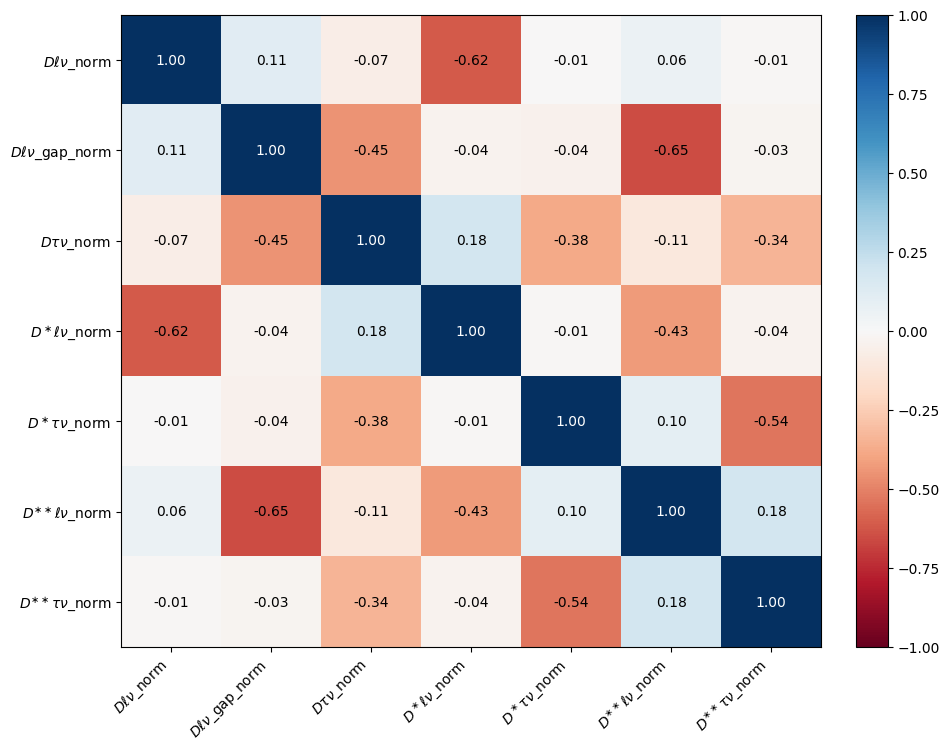

In [19]:
# 3/ab template with weight=0.12 and no staterror
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.35)

INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3955                       │              Nfcn = 73               │
│ EDM = 2.23e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 3955.304735 at

W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3960                       │        Nfcn = 101, Ngrad = 9         │
│ EDM = 0.000513 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 3960.403538 at

DEBUG - cabinetry.fit - -2 log(L) = 3957.894671 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 0.565
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3958                       │         Nfcn = 99, Ngrad = 8         │
│ EDM = 1.63e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3956.059152 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 0.778
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3956                       │        Nfcn = 101, Ngrad = 8         │
│ EDM = 1.25e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3955.321419 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 0.990
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3955                       │         Nfcn = 75, Ngrad = 2         │
│ EDM = 0.000493 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3955.679596 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 1.202
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3956                       │         Nfcn = 95, Ngrad = 8         │
│ EDM = 1.37e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3957.135240 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 1.414
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3957                       │         Nfcn = 98, Ngrad = 9         │
│ EDM = 6.46e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3959.692705 at best-fit point
INFO - cabinetry.visualize.utils - saving figure as figures/scan_$D\tau\nu$_norm.pdf


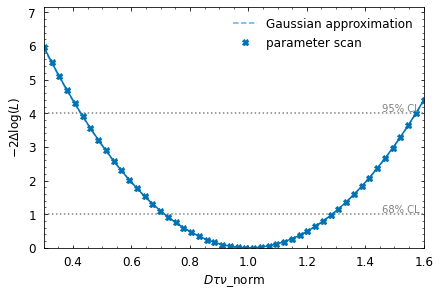

In [80]:
scan_0=cabinetry.fit.scan(model=model, data=data,par_name=r'$D\tau\nu$_norm',par_range=[0.3,1.6],n_steps=50)
cabinetry.visualize.scan(scan_0)

In [ ]:
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, log_scale=False)
for i in _:
    i['figure'].set_figwidth(12)

# 5. Test Toys workflow

## Simple toy (TBC)

INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier mu (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier uncorr_bkguncrt (1 new nuisance parameters)


Channels: ['singlechannel']
Samples: ['background', 'signal']
Parameters: ['mu', 'uncorr_bkguncrt']


INFO - cabinetry.visualize.utils - saving figure as figures/modifier_grid.pdf


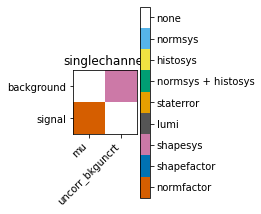

In [34]:
signal = 10000
background = 0
background_uncertainty = 0
model = pyhf.simplemodels.uncorrelated_background(
    [signal], [background], [background_uncertainty]
)
print(f"Channels: {model.config.channels}")
print(f"Samples: {model.config.samples}")
print(f"Parameters: {model.config.parameters}")

cabinetry.visualize.modifier_grid(model)

In [37]:
toy_pars = [0.1,1]
# generate the toys:
pdf_toy = model.make_pdf(pyhf.tensorlib.astensor(toy_pars))

toys = pdf_toy.sample((10000,))
toys

array([[ 991,    1],
       [1023,    1],
       [ 992,    3],
       ...,
       [ 973,    3],
       [ 994,    0],
       [ 991,    3]])

In [38]:
np.std(toys[:,0])

31.677470446833343

(array([ 21.,  67., 259., 469., 568., 361., 200.,  46.,   8.,   1.]),
 array([ 903. ,  925.3,  947.6,  969.9,  992.2, 1014.5, 1036.8, 1059.1,
        1081.4, 1103.7, 1126. ]),
 <BarContainer object of 10 artists>)

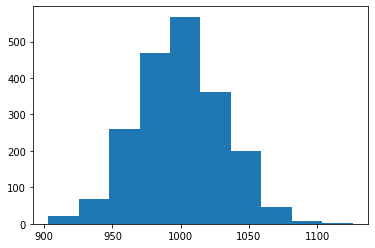

In [17]:
plt.hist(toys[:,0])

## More practical toys

In [80]:
spec_e = cabinetry.workspace.load('../Toys_pipeline/2d_ws_SR_e_50_50_allUncer.json')
spec_e_sb = cabinetry.workspace.load('../Toys_pipeline/2d_ws_SR_e_50_50_SBFakeD_allUncer_1ab.json')
model_sr, data_sr = cabinetry.model_utils.model_and_data(spec_e,include_auxdata=True)
model_sbFakeD, data_sbFakeD = cabinetry.model_utils.model_and_data(spec_e_sb)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

In [56]:
0 in model_sr.expected_actualdata(model_sr.config.suggested_init())

False

In [7]:
0 in model_sbFakeD.expected_actualdata([1]*1111)

False

In [ ]:
cabinetry.model_utils.asimov_parameters(model_sr)

In [83]:
model_sr.expected_auxdata(model_sr.config.suggested_init())[845:865]

Array([16.        ,  1.        ,  1.        ,  6.99974237,  2.9998296 ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ],      dtype=float64)

In [84]:
model_sbFakeD.expected_auxdata(model_sbFakeD.config.suggested_init())[902:922]

Array([ 1.        ,  1.        ,  2.00016961, 20.00030396,  4.91195476,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ],      dtype=float64)

In [65]:
toy_par = model_sbFakeD.config.suggested_init()
toy_par[:12] = [0.4]*12
model_sbFakeD.expected_auxdata(toy_par)[:10]

array([ 36.79679156, 140.26047076,  23.72735893, 155.85183087,
       140.19613899,   1.9655761 ,  14.00007277,   1.        ,
         1.        ,   8.19241957])

In [45]:
samples_toFix = ['bkg_fakeD','bkg_TDFl','bkg_continuum',
                 'bkg_combinatorial','bkg_singleBbkg','bkg_fakeTracks',]

model_test = model_sr
model_temp = model_sbFakeD
        
# Get the list of all sample names from the model
all_sample_names = model_sr.config.samples
# Create a boolean list for fixing parameters
fix_mask = [sample in samples_toFix for sample in all_sample_names]
        
# Retrieve all parameter names in the correct order
all_parameter_names = model_sr.config.par_order
# Create a list of parameter names for samples that are not fixed
minos_parameters = [param for param, fix in zip(all_parameter_names, fix_mask) if not fix]
        
# Generate toys   
toy_pars = model_test.config.suggested_init()
toy_pars[:12] = [1]*12
# generate the toys:
pdf_toy = model_test.make_pdf(pyhf.tensorlib.astensor(toy_pars))

toys = pdf_toy.sample((3,))

In [ ]:
pyhf.set_backend('jax', 'scipy')
init_pars = pyhf.infer.mle.fit(data=data_sr, pdf=model_sr,
                               init_pars=toy_pars,
                               fixed_params=fix_mask,
                              ).tolist()
init_pars[:12]

In [63]:
pyhf.set_backend('jax', 'minuit')
res = cabinetry.fit.fit(
    model_temp,
    data=model_sr.expected_data(model_sr.config.suggested_init()),
    init_pars=toy_pars,
    fix_pars = fix_mask,
    # par_bounds=par_bounds,
    goodness_of_fit=True,
#     minos=minos_parameters
)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3550                       │      Nfcn = 423563, Ngrad = 22       │
│ EDM = 6.44e-05 (Goal: 0.0002)    │           time = 317.6 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

INFO - cabinetry.fit - mc_uncer_channel0[88]      =  1.0195 +/- 0.1197
INFO - cabinetry.fit - mc_uncer_channel0[89]      =  1.0000 +/- 0.3527
INFO - cabinetry.fit - mc_uncer_channel0[90]      =  0.9863 +/- 0.1699
INFO - cabinetry.fit - mc_uncer_channel0[91]      =  1.0029 +/- 0.0288
INFO - cabinetry.fit - mc_uncer_channel0[92]      =  1.0003 +/- 0.0217
INFO - cabinetry.fit - mc_uncer_channel0[93]      =  0.9630 +/- 0.2373
INFO - cabinetry.fit - mc_uncer_channel0[94]      =  1.0095 +/- 0.0272
INFO - cabinetry.fit - mc_uncer_channel0[95]      =  0.9954 +/- 0.0480
INFO - cabinetry.fit - mc_uncer_channel0[96]      =  1.0577 +/- 0.2494
INFO - cabinetry.fit - mc_uncer_channel0[97]      =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[98]      =  1.0252 +/- 0.2379
INFO - cabinetry.fit - mc_uncer_channel0[99]      =  1.0207 +/- 0.1242
INFO - cabinetry.fit - mc_uncer_channel0[100]     =  1.1180 +/- 0.3528
INFO - cabinetry.fit - mc_uncer_channel0[101]     =  1.0246 +/- 0.2382
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[204]     =  0.9465 +/- 0.1145
INFO - cabinetry.fit - mc_uncer_channel0[205]     =  0.9834 +/- 0.0342
INFO - cabinetry.fit - mc_uncer_channel0[206]     =  1.0041 +/- 0.0307
INFO - cabinetry.fit - mc_uncer_channel0[207]     =  1.0516 +/- 0.2352
INFO - cabinetry.fit - mc_uncer_channel0[208]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[209]     =  0.9727 +/- 0.2385
INFO - cabinetry.fit - mc_uncer_channel0[210]     =  1.0441 +/- 0.1343
INFO - cabinetry.fit - mc_uncer_channel0[211]     =  0.9993 +/- 0.0307
INFO - cabinetry.fit - mc_uncer_channel0[212]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[213]     =  1.0069 +/- 0.0987
INFO - cabinetry.fit - mc_uncer_channel0[214]     =  1.0187 +/- 0.0601
INFO - cabinetry.fit - mc_uncer_channel0[215]     =  1.0003 +/- 0.0166
INFO - cabinetry.fit - mc_uncer_channel0[216]     =  1.0026 +/- 0.0238
INFO - cabinetry.fit - mc_uncer_channel0[217]     =  1.0000 +/- 0.7006
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[320]     =  0.9991 +/- 0.0176
INFO - cabinetry.fit - mc_uncer_channel0[321]     =  1.0723 +/- 0.1095
INFO - cabinetry.fit - mc_uncer_channel0[322]     =  1.0073 +/- 0.0265
INFO - cabinetry.fit - mc_uncer_channel0[323]     =  0.9852 +/- 0.0624
INFO - cabinetry.fit - mc_uncer_channel0[324]     =  0.9937 +/- 0.0235
INFO - cabinetry.fit - mc_uncer_channel0[325]     =  1.0764 +/- 0.1413
INFO - cabinetry.fit - mc_uncer_channel0[326]     =  0.9972 +/- 0.0248
INFO - cabinetry.fit - mc_uncer_channel0[327]     =  1.0209 +/- 0.0600
INFO - cabinetry.fit - mc_uncer_channel0[328]     =  1.0000 +/- 0.3527
INFO - cabinetry.fit - mc_uncer_channel0[329]     =  0.9958 +/- 0.0159
INFO - cabinetry.fit - mc_uncer_channel0[330]     =  1.0233 +/- 0.1425
INFO - cabinetry.fit - mc_uncer_channel0[331]     =  0.9961 +/- 0.0569
INFO - cabinetry.fit - mc_uncer_channel0[332]     =  1.0170 +/- 0.0292
INFO - cabinetry.fit - mc_uncer_channel0[333]     =  0.9195 +/- 0.4227
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[436]     =  1.0094 +/- 0.1351
INFO - cabinetry.fit - mc_uncer_channel0[437]     =  1.0022 +/- 0.0161
INFO - cabinetry.fit - mc_uncer_channel0[438]     =  1.0338 +/- 0.0912
INFO - cabinetry.fit - mc_uncer_channel0[439]     =  1.0125 +/- 0.0321
INFO - cabinetry.fit - mc_uncer_channel0[440]     =  0.9962 +/- 0.0286
INFO - cabinetry.fit - mc_uncer_channel0[441]     =  0.9539 +/- 0.2598
INFO - cabinetry.fit - mc_uncer_channel0[442]     =  1.0321 +/- 0.2033
INFO - cabinetry.fit - mc_uncer_channel0[443]     =  1.0000 +/- 0.3527
INFO - cabinetry.fit - mc_uncer_channel0[444]     =  1.0438 +/- 0.0755
INFO - cabinetry.fit - mc_uncer_channel0[445]     =  1.0010 +/- 0.0423
INFO - cabinetry.fit - mc_uncer_channel0[446]     =  1.0100 +/- 0.1463
INFO - cabinetry.fit - mc_uncer_channel0[447]     =  1.0000 +/- 0.2882
INFO - cabinetry.fit - mc_uncer_channel0[448]     =  0.9904 +/- 0.0204
INFO - cabinetry.fit - mc_uncer_channel0[449]     =  0.9976 +/- 0.0509
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[552]     =  0.9979 +/- 0.0189
INFO - cabinetry.fit - mc_uncer_channel0[553]     =  1.0011 +/- 0.0329
INFO - cabinetry.fit - mc_uncer_channel0[554]     =  1.0193 +/- 0.1471
INFO - cabinetry.fit - mc_uncer_channel0[555]     =  1.0004 +/- 0.0212
INFO - cabinetry.fit - mc_uncer_channel0[556]     =  1.0007 +/- 0.0924
INFO - cabinetry.fit - mc_uncer_channel0[557]     =  1.0641 +/- 0.0777
INFO - cabinetry.fit - mc_uncer_channel0[558]     =  1.0000 +/- 0.3527
INFO - cabinetry.fit - mc_uncer_channel0[559]     =  1.1446 +/- 0.1766
INFO - cabinetry.fit - mc_uncer_channel0[560]     =  0.9951 +/- 0.0291
INFO - cabinetry.fit - mc_uncer_channel0[561]     =  1.0253 +/- 0.0897
INFO - cabinetry.fit - mc_uncer_channel0[562]     =  1.0761 +/- 0.2877
INFO - cabinetry.fit - mc_uncer_channel0[563]     =  1.0436 +/- 0.1157
INFO - cabinetry.fit - mc_uncer_channel0[564]     =  0.9979 +/- 0.0172
INFO - cabinetry.fit - mc_uncer_channel0[565]     =  1.1840 +/- 0.1785
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[668]     =  0.9970 +/- 0.2493
INFO - cabinetry.fit - mc_uncer_channel0[669]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[670]     =  1.0002 +/- 0.0236
INFO - cabinetry.fit - mc_uncer_channel0[671]     =  1.0070 +/- 0.0238
INFO - cabinetry.fit - mc_uncer_channel0[672]     =  0.9993 +/- 0.0203
INFO - cabinetry.fit - mc_uncer_channel0[673]     =  1.0842 +/- 0.0795
INFO - cabinetry.fit - mc_uncer_channel0[674]     =  1.0290 +/- 0.1422
INFO - cabinetry.fit - mc_uncer_channel0[675]     =  1.0065 +/- 0.0251
INFO - cabinetry.fit - mc_uncer_channel0[676]     =  0.9968 +/- 0.0698
INFO - cabinetry.fit - mc_uncer_channel0[677]     =  0.9869 +/- 0.0270
INFO - cabinetry.fit - mc_uncer_channel0[678]     =  0.9994 +/- 0.0243
INFO - cabinetry.fit - mc_uncer_channel0[679]     =  1.0163 +/- 0.1904
INFO - cabinetry.fit - mc_uncer_channel0[680]     =  1.0502 +/- 0.1640
INFO - cabinetry.fit - mc_uncer_channel0[681]     =  1.0125 +/- 0.1970
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[784]     =  0.9989 +/- 0.2668
INFO - cabinetry.fit - mc_uncer_channel0[785]     =  1.0034 +/- 0.0380
INFO - cabinetry.fit - mc_uncer_channel0[786]     =  1.0146 +/- 0.1777
INFO - cabinetry.fit - mc_uncer_channel0[787]     =  1.0338 +/- 0.1347
INFO - cabinetry.fit - mc_uncer_channel0[788]     =  1.0191 +/- 0.1425
INFO - cabinetry.fit - mc_uncer_channel0[789]     =  0.9270 +/- 0.1501
INFO - cabinetry.fit - mc_uncer_channel0[790]     =  0.9980 +/- 0.0170
INFO - cabinetry.fit - mc_uncer_channel0[791]     =  0.9932 +/- 0.0241
INFO - cabinetry.fit - mc_uncer_channel0[792]     =  0.9294 +/- 0.3197
INFO - cabinetry.fit - mc_uncer_channel0[793]     =  0.9950 +/- 0.4060
INFO - cabinetry.fit - mc_uncer_channel0[794]     =  1.0164 +/- 0.0526
INFO - cabinetry.fit - mc_uncer_channel0[795]     =  0.9886 +/- 0.0389
INFO - cabinetry.fit - mc_uncer_channel0[796]     =  1.0123 +/- 0.2100
INFO - cabinetry.fit - mc_uncer_channel0[797]     =  0.9752 +/- 0.0884
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[900]     =  0.9941 +/- 0.0362
INFO - cabinetry.fit - mc_uncer_channel0[901]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[902]     =  1.0000 +/- 0.2234
INFO - cabinetry.fit - mc_uncer_channel0[903]     =  0.9731 +/- 0.2386
INFO - cabinetry.fit - mc_uncer_channel0[904]     =  1.1972 +/- 0.1246
INFO - cabinetry.fit - mc_uncer_channel0[905]     =  0.9993 +/- 0.0502
INFO - cabinetry.fit - calculating goodness-of-fit
DEBUG - cabinetry.fit - Delta NLL = 57.265140
DEBUG - cabinetry.fit - number of degrees of freedom: 894
INFO - cabinetry.fit - p-value for goodness-of-fit test: 100.00%


INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


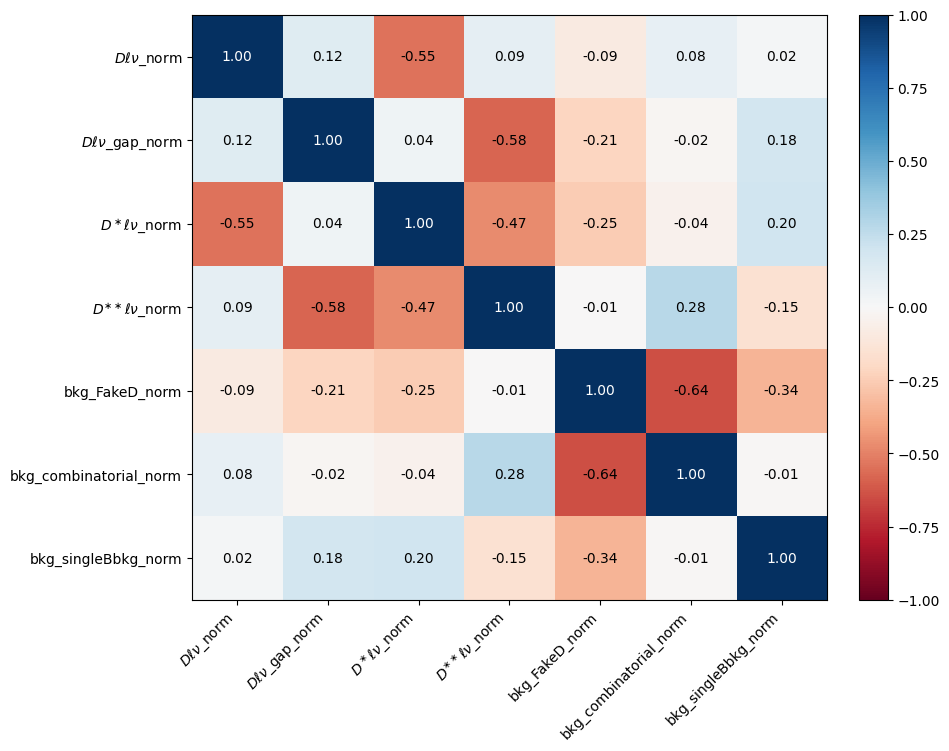

In [15]:
# 3/ab template with weight=0.12 and no staterror
cabinetry.visualize.correlation_matrix(res, pruning_threshold=0.3)

In [96]:
temp_2d, stat_2d,data_2d = util.create_2d_template(
    template_flat=temp_asimov_e[0],
    staterror_flat=temp_asimov_e[1],
    data_flat=toys[0][:1136],
    indices_threshold=indices_threshold_e,
    bins=[MM2_bins, p_D_l_bins])

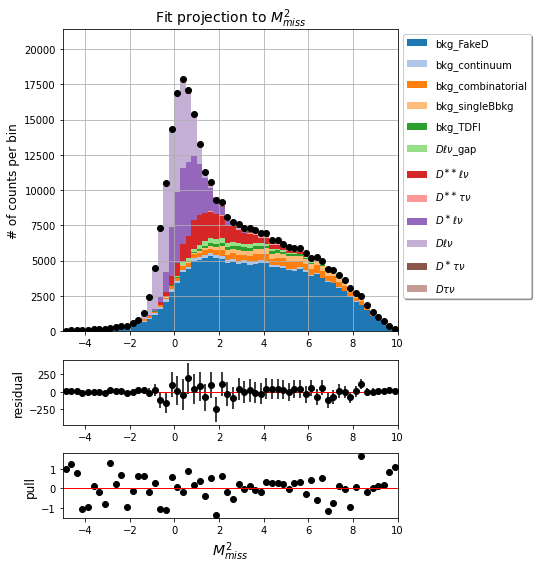

In [97]:
fig = util.fit_project_cabinetry(fit_result=res, templates_2d=temp_2d,
                      staterror_2d=stat_2d,data_2d=data_2d, 
                      edges_list=[MM2_bins, p_D_l_bins], 
                      direction='mm2', slice_thresholds=None)

In [ ]:
fig = util.fit_project_cabinetry(fit_result=res, templates_2d=temp_2d,
                      staterror_2d=stat_2d,data_2d=data_2d, 
                      edges_list=[MM2_bins, p_D_l_bins], 
                      direction='p_D_l', slice_thresholds=None)

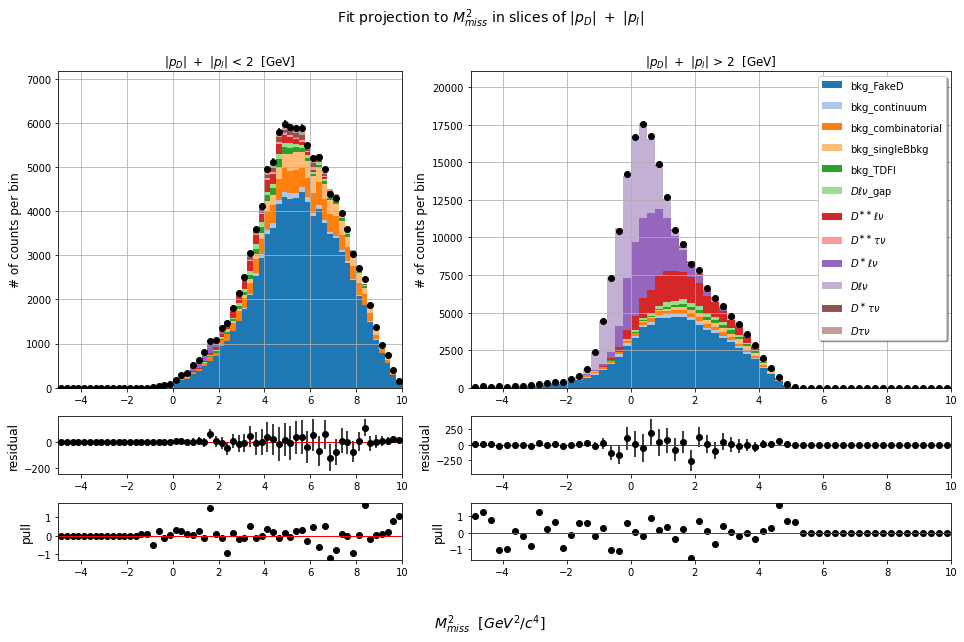

In [99]:
fig = util.fit_project_cabinetry(fit_result=res, templates_2d=temp_2d,
                      staterror_2d=stat_2d,data_2d=data_2d, 
                      edges_list=[MM2_bins, p_D_l_bins], 
                      direction='mm2', slice_thresholds=[2,2])

In [ ]:
fig = util.fit_project_cabinetry(fit_result=res, templates_2d=temp_2d,
                      staterror_2d=stat_2d,data_2d=data_2d, 
                      edges_list=[MM2_bins, p_D_l_bins], 
                      direction='p_D_l', slice_thresholds=[2,2])

DEBUG - cabinetry.model_utils - total stdev is [[1, 2.24, 1.41, 2.24, 1.73, 1.41, 2.65, ..., 5.2, 1, 2, 3.87, 1, 1, 1], ...]
DEBUG - cabinetry.model_utils - total stdev per channel is [300, 300]
INFO - cabinetry.visualize.utils - saving figure as figures/e_channel_prefit.pdf
INFO - cabinetry.visualize.utils - saving figure as figures/mu_channel_prefit.pdf


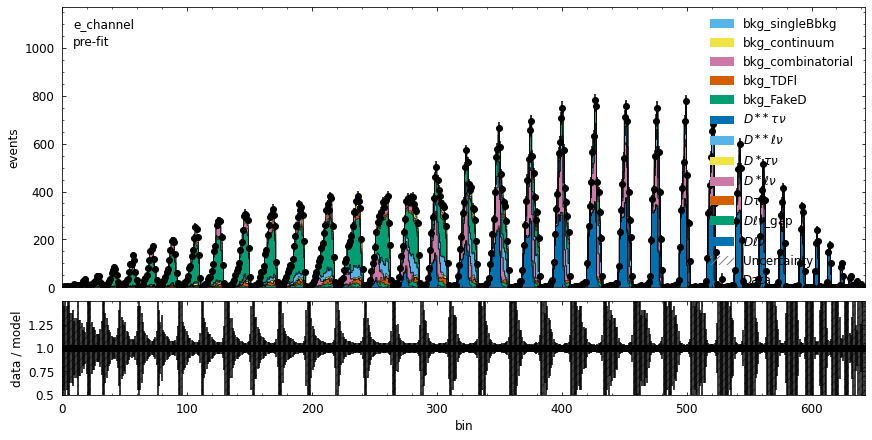

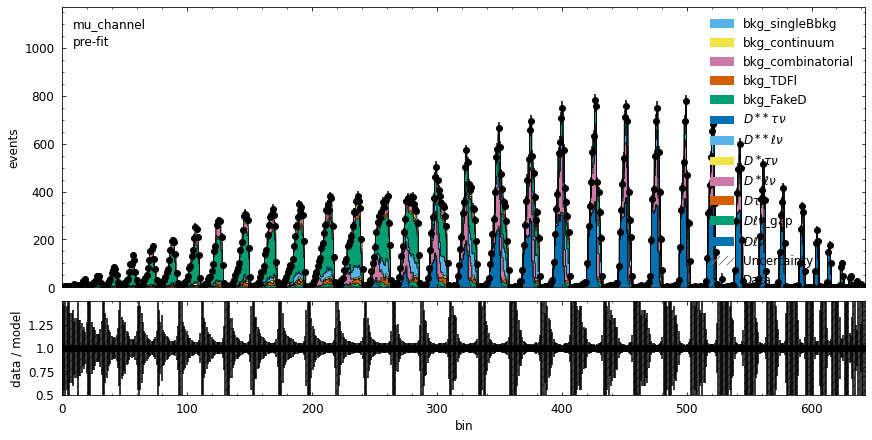

In [21]:
model_pred_prefit = cabinetry.model_utils.prediction(model)
#plt.figure(figsize=(16,6))
dms = cabinetry.visualize.data_mc(model_pred_prefit, data, log_scale=False)
for i in dms:
    i['figure'].set_figwidth(12)

# 6. BDT/Binning vs. fit uncertainty

In [3]:
## Loading Ntuples
columns = util.all_relevant_variables

cut = '(5<B0_roeMbc_my_mask) & (-4<B0_roeDeltae_my_mask) & (B0_roeDeltae_my_mask<1)'

# Load data files
e_generic = uproot.concatenate([f'../Samples/Generic_MC15ri/e_channel/MC15ri_1ab_quaxo_e_2/*.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

In [4]:
df_e_generic = pd.DataFrame(e_generic).sample(frac=0.4).reset_index(drop=True)
df_e_generic.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
df_e_generic.eval('p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

In [17]:
# Define the fitting range and number of bins, 'p_D_l'
start = 0.4
end = 4.8
num_bins = 50

# Create the bin edges
p_D_l_bins = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -2.5
end = 10
num_bins = 50

# Create the bin edges
MM2_bins = np.linspace(start, end, num_bins + 1)


# Check for empty bins
# empty_bins = [41, 42, 43, 44, 46, 47, 48, 49]

# Merge adjacent empty bins
# merged_bins = np.delete(bins, empty_bins)

# Define relevant variables
training_variables = util.training_variables

In [6]:
err2 = []
  
lgb_tight = 'sig_prob==largest_prob and sig_prob>0.65 and fakeD_prob<0.05'

df_e_generic_lgb = util.apply_mva_bcs(df_e_generic, training_variables, lgb_tight, library='lgbm')

t_e_generic = util.get_dataframe_samples_new(df_e_generic_lgb, 'e', template=False)
    

In [18]:
for test_point in np.linspace(1,20,20):
    print('testing point at', test_point)
    indices_threshold_e,temp_asimov_e,temp_with_sb,temp_asimov_merged_e = util.create_templates(
        samples=t_e_generic, bins=[MM2_bins, p_D_l_bins], scale_lumi=1, fakeD_from_sideband=True,
        data = None, #df_e_generic_lgb.query('D_M<1.83 or 1.91<D_M').sample(frac=0.4),
        variables=['B0_CMS3_weMissM2','p_D_l'], bin_threshold=test_point,merge_threshold=5,
        sample_to_exclude=['bkg_fakeTracks','bkg_other_TDTl','bkg_other_signal'],
        sample_weights={r'$D^{\ast\ast}\ell\nu$_broad':1,
                        r'$D\ell\nu$_gap_pi':1, 
                        r'$D\ell\nu$_gap_eta':1,
                        })

    workspace_path = '2d_ws_SR_1ch.json'
    spec = cabinetry.workspace.load(workspace_path)
    spec_e = util.update_workspace(workspace=spec,
                                 temp_asimov_channels=[temp_asimov_e],
                                 mc_uncer=False,fakeD_uncer=False)
    model_sr, data_sr = cabinetry.model_utils.model_and_data(spec_e)

    pyhf.set_backend("jax")
    fit_results = cabinetry.fit.fit(model=model_sr, data=data_sr,
                                fix_pars=[False, True, False, False, True, False, True] +[True]*5)

    err2.append(fit_results.uncertainty[model_sr.config.par_map[r'$D\tau\nu$_norm']['slice']])

testing point at 1.0
Creating the fakeD template from the sidebands
initial parameters= [ 1.4125e+03  1.8700e+00  7.0000e-02  1.4125e+04 -6.2860e+02  1.6470e+03]
Yields from 1.79 to 1.82: 7677.742
Yields from 1.855 to 1.885: 7062.12
Yields from 1.92 to 1.95: 6446.498
yields_sig/yields_left=0.9198173108708263, yields_sig/yields_right=1.0954971210725575
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 839, now is 831
creating a new template with merged bins, original template length = 831, new template (merge small bins) length = 666


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

W VariableMetricBuilder No improvement in line search
testing point at 2.0
Creating the fakeD template from the sidebands
initial parameters= [ 1.4125e+03  1.8700e+00  7.0000e-02  1.4125e+04 -6.2860e+02  1.6470e+03]
Yields from 1.79 to 1.82: 7677.742
Yields from 1.855 to 1.885: 7062.12
Yields from 1.92 to 1.95: 6446.498
yields_sig/yields_left=0.9198173108708263, yields_sig/yields_right=1.0954971210725575
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 766, now is 762
creating a new template with merged bins, original template length = 762, new template (merge small bins) length = 660


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4108                       │              Nfcn = 28               │
│ EDM = 4.55e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 4108.370481 at

testing point at 3.0
Creating the fakeD template from the sidebands
initial parameters= [ 1.4125e+03  1.8700e+00  7.0000e-02  1.4125e+04 -6.2860e+02  1.6470e+03]
Yields from 1.79 to 1.82: 7677.742
Yields from 1.855 to 1.885: 7062.12
Yields from 1.92 to 1.95: 6446.498
yields_sig/yields_left=0.9198173108708263, yields_sig/yields_right=1.0954971210725575
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 716, now is 708
creating a new template with merged bins, original template length = 708, new template (merge small bins) length = 648


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

W VariableMetricBuilder No improvement in line search
testing point at 4.0
Creating the fakeD template from the sidebands
initial parameters= [ 1.4125e+03  1.8700e+00  7.0000e-02  1.4125e+04 -6.2860e+02  1.6470e+03]
Yields from 1.79 to 1.82: 7677.742
Yields from 1.855 to 1.885: 7062.12
Yields from 1.92 to 1.95: 6446.498
yields_sig/yields_left=0.9198173108708263, yields_sig/yields_right=1.0954971210725575
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 684, now is 674
creating a new template with merged bins, original template length = 674, new template (merge small bins) length = 647


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

W VariableMetricBuilder No improvement in line search
testing point at 5.0
Creating the fakeD template from the sidebands
initial parameters= [ 1.4125e+03  1.8700e+00  7.0000e-02  1.4125e+04 -6.2860e+02  1.6470e+03]
Yields from 1.79 to 1.82: 7677.742
Yields from 1.855 to 1.885: 7062.12
Yields from 1.92 to 1.95: 6446.498
yields_sig/yields_left=0.9198173108708263, yields_sig/yields_right=1.0954971210725575
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 647, now is 633
creating a new template with merged bins, original template length = 633, new template (merge small bins) length = 633


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

W VariableMetricBuilder No improvement in line search
testing point at 6.0
Creating the fakeD template from the sidebands
initial parameters= [ 1.4125e+03  1.8700e+00  7.0000e-02  1.4125e+04 -6.2860e+02  1.6470e+03]
Yields from 1.79 to 1.82: 7677.742
Yields from 1.855 to 1.885: 7062.12
Yields from 1.92 to 1.95: 6446.498
yields_sig/yields_left=0.9198173108708263, yields_sig/yields_right=1.0954971210725575
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 607, now is 593
creating a new template with merged bins, original template length = 593, new template (merge small bins) length = 593


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

W VariableMetricBuilder No improvement in line search
testing point at 7.0
Creating the fakeD template from the sidebands
initial parameters= [ 1.4125e+03  1.8700e+00  7.0000e-02  1.4125e+04 -6.2860e+02  1.6470e+03]
Yields from 1.79 to 1.82: 7677.742
Yields from 1.855 to 1.885: 7062.12
Yields from 1.92 to 1.95: 6446.498
yields_sig/yields_left=0.9198173108708263, yields_sig/yields_right=1.0954971210725575
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 581, now is 569
creating a new template with merged bins, original template length = 569, new template (merge small bins) length = 569


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

W VariableMetricBuilder No improvement in line search
testing point at 8.0
Creating the fakeD template from the sidebands
initial parameters= [ 1.4125e+03  1.8700e+00  7.0000e-02  1.4125e+04 -6.2860e+02  1.6470e+03]
Yields from 1.79 to 1.82: 7677.742
Yields from 1.855 to 1.885: 7062.12
Yields from 1.92 to 1.95: 6446.498
yields_sig/yields_left=0.9198173108708263, yields_sig/yields_right=1.0954971210725575
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 555, now is 543
creating a new template with merged bins, original template length = 543, new template (merge small bins) length = 543


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

W VariableMetricBuilder No improvement in line search
testing point at 9.0
Creating the fakeD template from the sidebands
initial parameters= [ 1.4125e+03  1.8700e+00  7.0000e-02  1.4125e+04 -6.2860e+02  1.6470e+03]
Yields from 1.79 to 1.82: 7677.742
Yields from 1.855 to 1.885: 7062.12
Yields from 1.92 to 1.95: 6446.498
yields_sig/yields_left=0.9198173108708263, yields_sig/yields_right=1.0954971210725575
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 537, now is 527
creating a new template with merged bins, original template length = 527, new template (merge small bins) length = 527


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

W VariableMetricBuilder No improvement in line search
testing point at 10.0
Creating the fakeD template from the sidebands
initial parameters= [ 1.4125e+03  1.8700e+00  7.0000e-02  1.4125e+04 -6.2860e+02  1.6470e+03]
Yields from 1.79 to 1.82: 7677.742
Yields from 1.855 to 1.885: 7062.12
Yields from 1.92 to 1.95: 6446.498
yields_sig/yields_left=0.9198173108708263, yields_sig/yields_right=1.0954971210725575
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 509, now is 500
creating a new template with merged bins, original template length = 500, new template (merge small bins) length = 500


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

W VariableMetricBuilder No improvement in line search
testing point at 11.0
Creating the fakeD template from the sidebands
initial parameters= [ 1.4125e+03  1.8700e+00  7.0000e-02  1.4125e+04 -6.2860e+02  1.6470e+03]
Yields from 1.79 to 1.82: 7677.742
Yields from 1.855 to 1.885: 7062.12
Yields from 1.92 to 1.95: 6446.498
yields_sig/yields_left=0.9198173108708263, yields_sig/yields_right=1.0954971210725575
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 495, now is 485
creating a new template with merged bins, original template length = 485, new template (merge small bins) length = 485


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

W VariableMetricBuilder No improvement in line search
testing point at 12.0
Creating the fakeD template from the sidebands
initial parameters= [ 1.4125e+03  1.8700e+00  7.0000e-02  1.4125e+04 -6.2860e+02  1.6470e+03]
Yields from 1.79 to 1.82: 7677.742
Yields from 1.855 to 1.885: 7062.12
Yields from 1.92 to 1.95: 6446.498
yields_sig/yields_left=0.9198173108708263, yields_sig/yields_right=1.0954971210725575
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 483, now is 474
creating a new template with merged bins, original template length = 474, new template (merge small bins) length = 474


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

W VariableMetricBuilder No improvement in line search
testing point at 13.0
Creating the fakeD template from the sidebands
initial parameters= [ 1.4125e+03  1.8700e+00  7.0000e-02  1.4125e+04 -6.2860e+02  1.6470e+03]
Yields from 1.79 to 1.82: 7677.742
Yields from 1.855 to 1.885: 7062.12
Yields from 1.92 to 1.95: 6446.498
yields_sig/yields_left=0.9198173108708263, yields_sig/yields_right=1.0954971210725575
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 473, now is 465
creating a new template with merged bins, original template length = 465, new template (merge small bins) length = 465


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

W VariableMetricBuilder No improvement in line search
testing point at 14.0
Creating the fakeD template from the sidebands
initial parameters= [ 1.4125e+03  1.8700e+00  7.0000e-02  1.4125e+04 -6.2860e+02  1.6470e+03]
Yields from 1.79 to 1.82: 7677.742
Yields from 1.855 to 1.885: 7062.12
Yields from 1.92 to 1.95: 6446.498
yields_sig/yields_left=0.9198173108708263, yields_sig/yields_right=1.0954971210725575
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 463, now is 455
creating a new template with merged bins, original template length = 455, new template (merge small bins) length = 455


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

W VariableMetricBuilder No improvement in line search
testing point at 15.0
Creating the fakeD template from the sidebands
initial parameters= [ 1.4125e+03  1.8700e+00  7.0000e-02  1.4125e+04 -6.2860e+02  1.6470e+03]
Yields from 1.79 to 1.82: 7677.742
Yields from 1.855 to 1.885: 7062.12
Yields from 1.92 to 1.95: 6446.498
yields_sig/yields_left=0.9198173108708263, yields_sig/yields_right=1.0954971210725575
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 455, now is 444
creating a new template with merged bins, original template length = 444, new template (merge small bins) length = 444


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

W VariableMetricBuilder No improvement in line search
testing point at 16.0
Creating the fakeD template from the sidebands
initial parameters= [ 1.4125e+03  1.8700e+00  7.0000e-02  1.4125e+04 -6.2860e+02  1.6470e+03]
Yields from 1.79 to 1.82: 7677.742
Yields from 1.855 to 1.885: 7062.12
Yields from 1.92 to 1.95: 6446.498
yields_sig/yields_left=0.9198173108708263, yields_sig/yields_right=1.0954971210725575
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 442, now is 436
creating a new template with merged bins, original template length = 436, new template (merge small bins) length = 436


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

W VariableMetricBuilder No improvement in line search
testing point at 17.0
Creating the fakeD template from the sidebands
initial parameters= [ 1.4125e+03  1.8700e+00  7.0000e-02  1.4125e+04 -6.2860e+02  1.6470e+03]
Yields from 1.79 to 1.82: 7677.742
Yields from 1.855 to 1.885: 7062.12
Yields from 1.92 to 1.95: 6446.498
yields_sig/yields_left=0.9198173108708263, yields_sig/yields_right=1.0954971210725575
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 440, now is 433
creating a new template with merged bins, original template length = 433, new template (merge small bins) length = 433


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

W VariableMetricBuilder No improvement in line search
testing point at 18.0
Creating the fakeD template from the sidebands
initial parameters= [ 1.4125e+03  1.8700e+00  7.0000e-02  1.4125e+04 -6.2860e+02  1.6470e+03]
Yields from 1.79 to 1.82: 7677.742
Yields from 1.855 to 1.885: 7062.12
Yields from 1.92 to 1.95: 6446.498
yields_sig/yields_left=0.9198173108708263, yields_sig/yields_right=1.0954971210725575
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 435, now is 428
creating a new template with merged bins, original template length = 428, new template (merge small bins) length = 428


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

W VariableMetricBuilder No improvement in line search
testing point at 19.0
Creating the fakeD template from the sidebands
initial parameters= [ 1.4125e+03  1.8700e+00  7.0000e-02  1.4125e+04 -6.2860e+02  1.6470e+03]
Yields from 1.79 to 1.82: 7677.742
Yields from 1.855 to 1.885: 7062.12
Yields from 1.92 to 1.95: 6446.498
yields_sig/yields_left=0.9198173108708263, yields_sig/yields_right=1.0954971210725575
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 429, now is 423
creating a new template with merged bins, original template length = 423, new template (merge small bins) length = 423


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

W VariableMetricBuilder No improvement in line search
testing point at 20.0
Creating the fakeD template from the sidebands
initial parameters= [ 1.4125e+03  1.8700e+00  7.0000e-02  1.4125e+04 -6.2860e+02  1.6470e+03]
Yields from 1.79 to 1.82: 7677.742
Yields from 1.855 to 1.885: 7062.12
Yields from 1.92 to 1.95: 6446.498
yields_sig/yields_left=0.9198173108708263, yields_sig/yields_right=1.0954971210725575
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 420, now is 415
creating a new template with merged bins, original template length = 415, new template (merge small bins) length = 415


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

W VariableMetricBuilder No improvement in line search


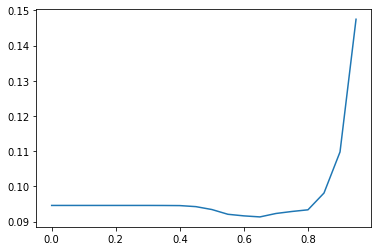

In [33]:
plt.plot(np.linspace(0,0.95,20),err)

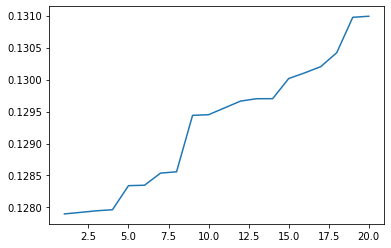

In [16]:
plt.plot(np.linspace(1,20,20),err2)

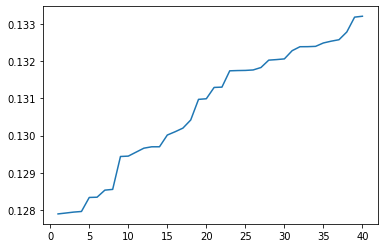

In [20]:
plt.plot(np.linspace(1,40,40),err2)